In [1]:
# PySpark 설정
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster('local').setAppName('spark-sql-intro')
sc = SparkContext(conf=conf)

In [2]:
# 주식종목(tickers), 주가정보(prices) RDD 생성

tickers = sc.parallelize([
    (1, ("Alphabet", "GOOGL", "USA")),
    (2, ("Netflix", "NFLX", "USA")),
    (3, ("Amazon", "AMZN", "USA")),
    (4, ("Tesla", "TSLA", "USA")),
    (5, ("Samsung Electronics", "005930", "Korea")),
    (6, ("Kakao", "035720", "Korea"))
])

prices = sc.parallelize([
    (1, (2373, "USD")),
    (2, (198, "USD")),
    (3, (2787, "USD")),
    (4, (1222, "USD")),
    (5, (70600, "KRW")),
    (6, (125000, "KRW"))
])

In [3]:
"""
    미국 주식 중 주가 $2000 이상의 주식만 가져오기
    첫 번째 방법: 조인 -> 필터링
"""

# [+] 내부조인을 통해 두 개의 RDD 합치기: tickers + prices
tickerPrice = tickers.join(prices)

In [4]:
sorted(tickerPrice.collect())

[(1, (('Alphabet', 'GOOGL', 'USA'), (2373, 'USD'))),
 (2, (('Netflix', 'NFLX', 'USA'), (198, 'USD'))),
 (3, (('Amazon', 'AMZN', 'USA'), (2787, 'USD'))),
 (4, (('Tesla', 'TSLA', 'USA'), (1222, 'USD'))),
 (5, (('Samsung Electronics', '005930', 'Korea'), (70600, 'KRW'))),
 (6, (('Kakao', '035720', 'Korea'), (125000, 'KRW')))]

+ (1, (('Alphabet', 'GOOGL', 'USA'), (2373, 'USD')) 의 인덱스 정보
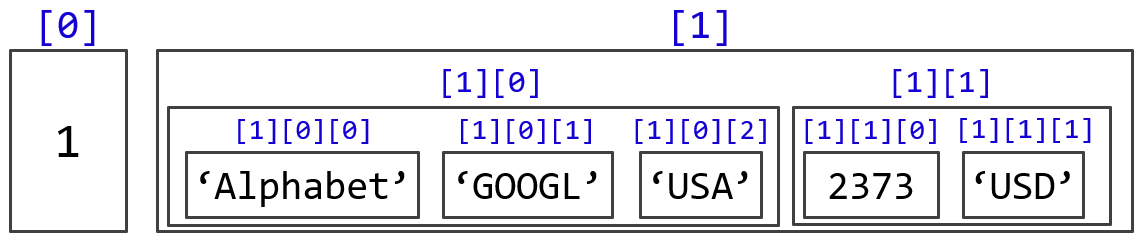

In [5]:
# [+] 필터링을 통해 $2000 이상의 미국 주식 출력하기
tickerPrice.filter(lambda x : x[1][0][2] == 'USA' and x[1][1][0] >= 2000).collect()

[(1, (('Alphabet', 'GOOGL', 'USA'), (2373, 'USD'))),
 (3, (('Amazon', 'AMZN', 'USA'), (2787, 'USD')))]

In [8]:
"""
    미국 주식 중 주가 $2000 이상의 주식만 가져오기
    두 번째 방법: 필터링 -> 조인
"""

# [+] 미국 주식만 필터링하기, 예제: (1, ("Alphabet", "GOOGL", "USA"))
filteredTicker = tickers.filter(lambda x : x[1][2] == 'USA')

In [9]:
filteredTicker.collect()

[(1, ('Alphabet', 'GOOGL', 'USA')),
 (2, ('Netflix', 'NFLX', 'USA')),
 (3, ('Amazon', 'AMZN', 'USA')),
 (4, ('Tesla', 'TSLA', 'USA'))]

In [10]:
# [+] 주가 2000 이상 주식만 필터링하기, 에제:  (1, (2373, "USD"))
filteredPrice = prices.filter(lambda x : x[1][0] >= 2000)

In [11]:
filteredPrice.collect()

[(1, (2373, 'USD')),
 (3, (2787, 'USD')),
 (5, (70600, 'KRW')),
 (6, (125000, 'KRW'))]

In [13]:
# [+] 내부조인을 통해 두 개의 RDD 합치기
tickerPrice = filteredTicker.join(filteredPrice)

In [14]:
tickerPrice.collect()

[(1, (('Alphabet', 'GOOGL', 'USA'), (2373, 'USD'))),
 (3, (('Amazon', 'AMZN', 'USA'), (2787, 'USD')))]

## DataFrame 객체 생성

In [15]:
# 예제 csv 파일
lines = sc.textFile('./data/example.csv')

In [16]:
# SparkSession 생성

from pyspark.sql import SparkSession, Row

spark = SparkSession.builder.appName('test-app').getOrCreate()

In [17]:
spark

+ example.csv: 
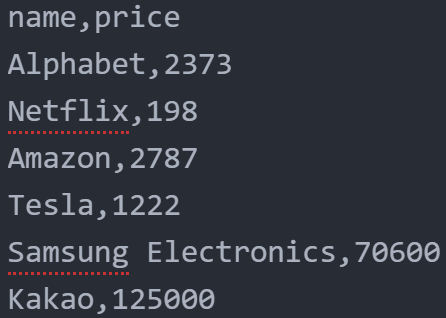

In [18]:
"""
    RDD로부터 DataFrame 객체 생성하기
"""
# 헤더 제거
header = lines.first()
filtered_lines = lines.filter(lambda x: x != header)
filtered_lines.collect()

['Alphabet,2373',
 'Netflix,198',
 'Amazon,2787',
 'Tesla,1222',
 'Samsung Electronics,70600',
 'Kakao,125000']

In [19]:
# 토크나이징
data = filtered_lines.map(lambda x: x.split(','))

In [20]:
data.collect()

[['Alphabet', '2373'],
 ['Netflix', '198'],
 ['Amazon', '2787'],
 ['Tesla', '1222'],
 ['Samsung Electronics', '70600'],
 ['Kakao', '125000']]

In [21]:
# 데이터 구조 정의
preprocessed = data.map(lambda x: Row(name=x[0], price=x[1]))  # 칼럼 지정

In [22]:
preprocessed.collect()

[Row(name='Alphabet', price='2373'),
 Row(name='Netflix', price='198'),
 Row(name='Amazon', price='2787'),
 Row(name='Tesla', price='1222'),
 Row(name='Samsung Electronics', price='70600'),
 Row(name='Kakao', price='125000')]

In [23]:
# createDataFrame() : DataFrame 객체를 생성
df = spark.createDataFrame(preprocessed)

In [25]:
# show(): DataFrame 내용 출력
df.show()

+-------------------+------+
|               name| price|
+-------------------+------+
|           Alphabet|  2373|
|            Netflix|   198|
|             Amazon|  2787|
|              Tesla|  1222|
|Samsung Electronics| 70600|
|              Kakao|125000|
+-------------------+------+



In [26]:
# printSchema() : DataFrame 스키마 출력
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)



In [27]:
# 스키마를 이용한 DataFrame 객체 생성: 엄격하게 타입체킹을 수행

from pyspark.sql.types import *

schema = StructType([
    StructField('name', StringType(), True),
    StructField('price',IntegerType(), True)
])

In [28]:
# 스키마와 함께 DataFrame 객체 생성
df = spark.createDataFrame(data, schema)

In [30]:
df.show()

Py4JJavaError: An error occurred while calling o237.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 17.0 failed 1 times, most recent failure: Lost task 0.0 in stage 17.0 (TID 21) (TaekwonLaptop executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 686, in main
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 678, in process
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\session.py", line 910, in prepare
    verify_func(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1722, in verify
    verify_value(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1700, in verify_struct
    verifier(v)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1722, in verify
    verify_value(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1635, in verify_integer
    verify_acceptable_types(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1592, in verify_acceptable_types
    raise TypeError(
TypeError: field price: IntegerType() can not accept object '2373' in type <class 'str'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1589)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2238)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2259)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2278)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 686, in main
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 678, in process
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\lib\pyspark.zip\pyspark\util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\session.py", line 910, in prepare
    verify_func(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1722, in verify
    verify_value(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1700, in verify_struct
    verifier(v)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1722, in verify
    verify_value(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1635, in verify_integer
    verify_acceptable_types(obj)
  File "C:\Dev\Spark\spark-3.3.2-bin-hadoop3\python\pyspark\sql\types.py", line 1592, in verify_acceptable_types
    raise TypeError(
TypeError: field price: IntegerType() can not accept object '2373' in type <class 'str'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


In [31]:
# price 값들을 정수형을 변환
data = data.map(lambda x: [x[0], int(x[1])])

In [32]:
data.collect()

[['Alphabet', 2373],
 ['Netflix', 198],
 ['Amazon', 2787],
 ['Tesla', 1222],
 ['Samsung Electronics', 70600],
 ['Kakao', 125000]]

In [33]:
df = spark.createDataFrame(data, schema)

In [34]:
df.show()

+-------------------+------+
|               name| price|
+-------------------+------+
|           Alphabet|  2373|
|            Netflix|   198|
|             Amazon|  2787|
|              Tesla|  1222|
|Samsung Electronics| 70600|
|              Kakao|125000|
+-------------------+------+



In [35]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)



In [36]:
"""
    파일로부터 DataFrame 객체 생성하기
        - SparkSession.read.json() : JSON 파일로부터 DataFrame 생성
        - SparkSession.read.text() : 텍스트 파일로부터 DataFrame 생성
        - SparkSession.read.csv() : CSV 파일로부터 DataFrame 생성
        - SparkSession.read.parquet() : Parquet 파일로부터 DataFrame 생성
          + Parquet: Impala 에서 사용하는 파일 포맷
"""

# csv 파일로부터 DataFrame 객체 생성하기
df = spark.read.csv('./data/example.csv', header=True)  # csv의 헤더를 인식해서 칼럼명으로 사용. False면 헤더를 칼럼이 아닌 값으로 인식한다.

In [37]:
df.show()

+-------------------+------+
|               name| price|
+-------------------+------+
|           Alphabet|  2373|
|            Netflix|   198|
|             Amazon|  2787|
|              Tesla|  1222|
|Samsung Electronics| 70600|
|              Kakao|125000|
+-------------------+------+



In [38]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)



In [39]:
# createOrReplaceTempView() : DataFrame 에 대해 SQL query 처리가 가능하도록 View 를 생성
df.createOrReplaceTempView("stock")

In [40]:
spark.sql("SELECT name FROM stock").show()

+-------------------+
|               name|
+-------------------+
|           Alphabet|
|            Netflix|
|             Amazon|
|              Tesla|
|Samsung Electronics|
|              Kakao|
+-------------------+



----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 55861)
